# GMM測試，程式修改自[Python Data Science Handbook 範例05.12-Gaussian-Mixtures.ipynb](https://github.com/jakevdp/PythonDataScienceHandbook)

## 載入相關套件

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 生成分類資料

In [2]:
from sklearn.datasets import make_blobs


X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
print(X[0])
X = X[:, ::-1] # 特徵互調順序，繪圖效果較佳
#X[:10]
print(X[0])

[0.25006446 6.48826703]
[6.48826703 0.25006446]


## 進行 K-Means 集群，並繪圖

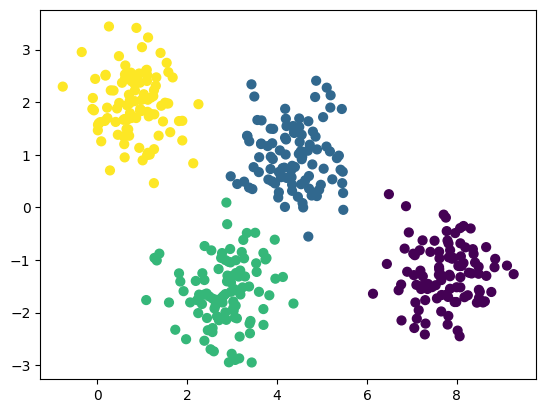

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(4, init='k-means++', n_init=10, random_state=0) # n_init:執行次數, random_state:隨機種子
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis') # c:顏色, s:點的大小, cmap:顏色樣式
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
# alpha:透明度, 0~1, 0表示完全透明, 1表示不透明

## 繪製集群範圍

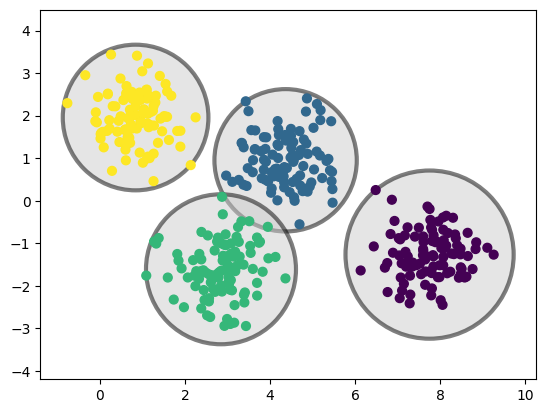

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X) # 執行 K-Means 分群

    # 繪製樣本點
    ax = ax or plt.gca() # gca(): get current axis
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2) # zorder:圖層順序

    # 以最大半徑繪製集群範圍
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, color='k', alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=0)
plot_kmeans(kmeans, X)

## 生成長條型資料

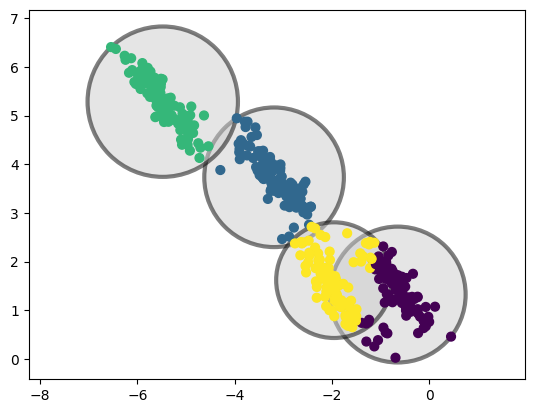

In [5]:
rng = np.random.RandomState(13) # 隨機數產生器
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=0)
plot_kmeans(kmeans, X_stretched)

## 改用GMM

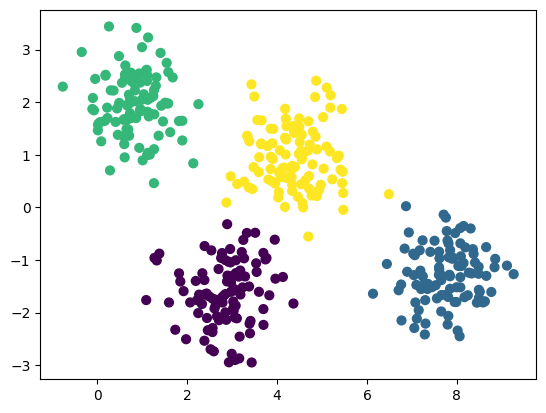

In [6]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

## 屬於各集群的機率

In [7]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.    0.537]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


## 繪製集群範圍

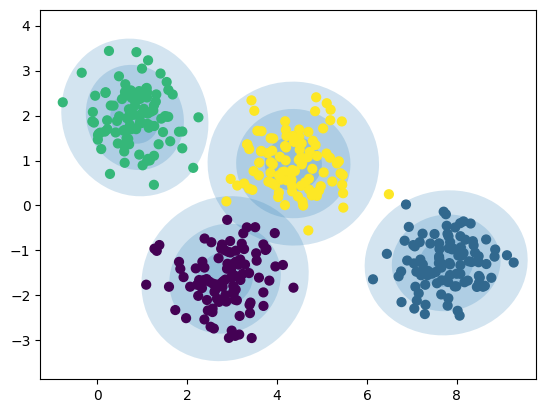

In [8]:
from matplotlib.patches import Ellipse

# 繪製橢圓
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, width=nsig * width, height=nsig * height,
                             angle=angle, **kwargs))
        
# 繪製GMM範圍
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    # soft-edged sphere 
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

## 使用 GMM對長條型資料進行集群

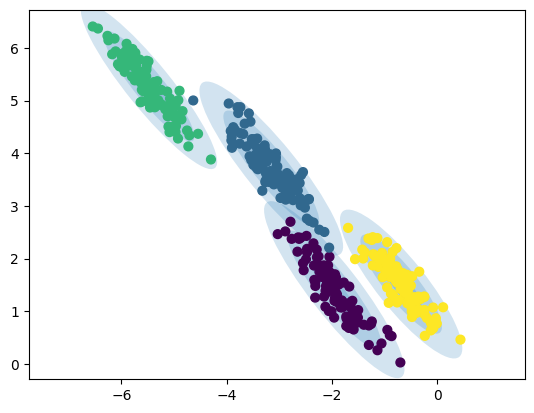

In [9]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## 測試非線性資料

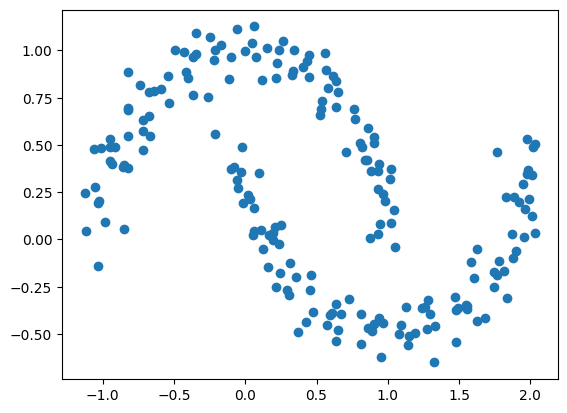

In [10]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=0.08, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

## GMM 集群：設定2個集群

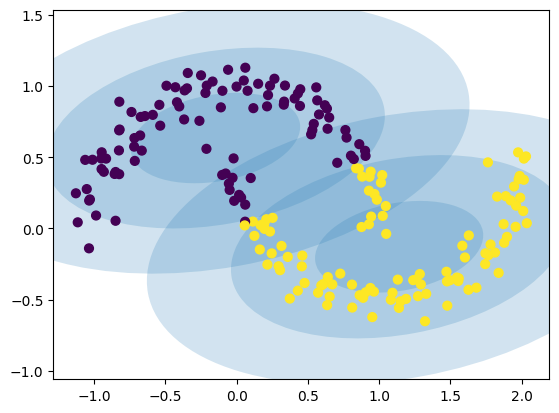

In [11]:
gmm2 = GaussianMixture(n_components=2, random_state=0)#, covariance_type='full'
plot_gmm(gmm2, Xmoon)

## GMM 集群：設定16個集群

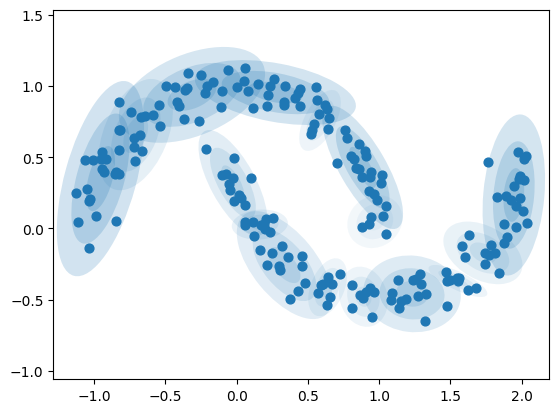

In [12]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

## 以模型生成資料

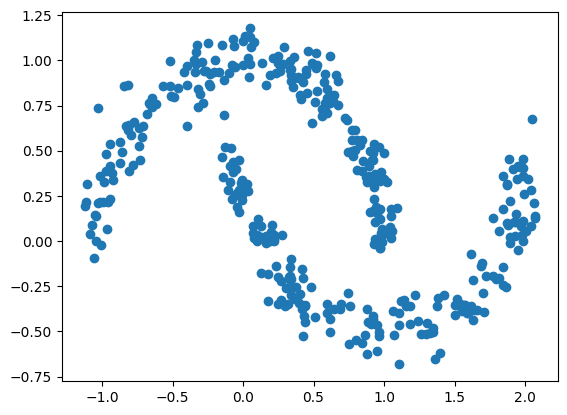

In [13]:
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

## 以AIC/BIC決定最佳集群數量

In [14]:
import warnings
# 忽略警告
warnings.filterwarnings('ignore')

Text(0.5, 0, 'n_components')

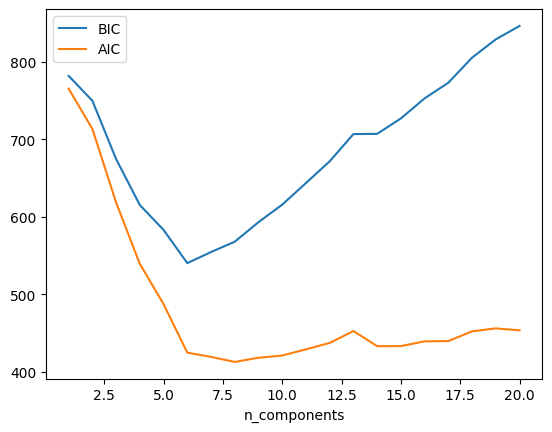

In [15]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

## 生成手寫阿拉伯數字

In [16]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

## 顯示前 100 筆手寫阿拉伯數字

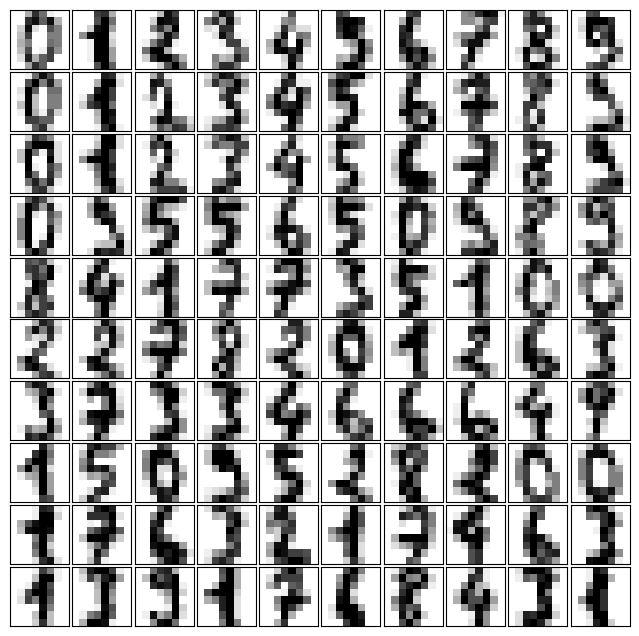

In [17]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

## 降維

In [18]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

## 以AIC決定最佳集群數量

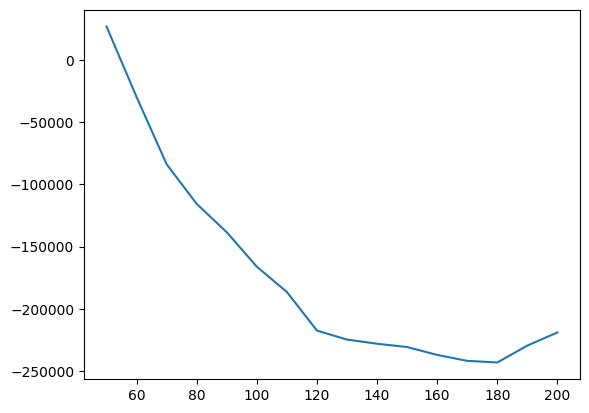

In [19]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full')
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

## 以AIC決定最佳集群數量=110

## 設定集群數量=110

In [20]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

## 生成100個樣本

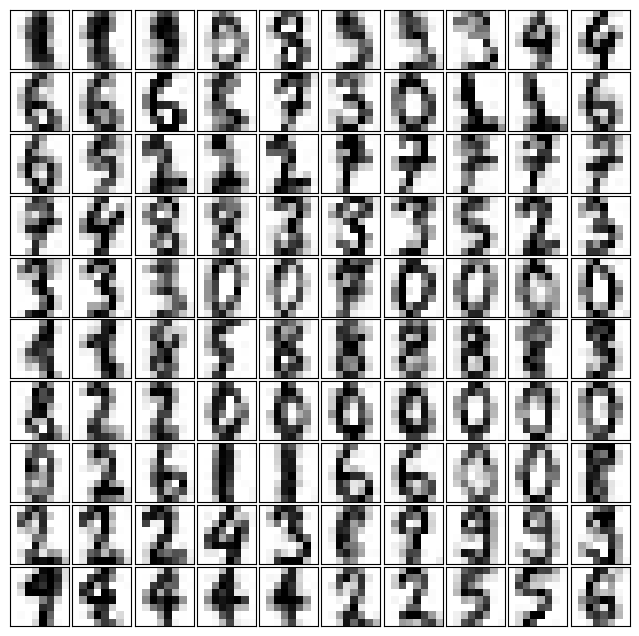

In [21]:
data_new, _ = gmm.sample(100)
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)